# IMPORTS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision import models
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATASET PREPROCESSING

## DATASET CLASS DEFINITION

In [ ]:
# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Ensure RGB format
        mask = Image.open(self.mask_paths[idx]).convert("L")      # Ensure grayscale format (single channel)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is binarized and float32
        mask = (mask > 0).float()  # Binarize mask (0 or 1)

        # Return image and mask, ensuring mask has the correct shape
        return image, mask.squeeze(0).unsqueeze(0)  # Make sure mask is [1, 256, 256]

## DATASET SPLIT

In [ ]:
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths
path_to_images = '/content/drive/MyDrive/DFUC2022 Dataset/DFUC2022_train_release/DFUC2022_train_images'
path_to_masks = '/content/drive/MyDrive/DFUC2022 Dataset/DFUC2022_train_release/DFUC2022_train_masks'

# Get sorted list of image and mask paths
image_paths = sorted([
    os.path.join(path_to_images, img) for img in os.listdir(path_to_images)
    if img.endswith('.jpg') or img.endswith('.jpeg')  # Include JPEG formats
])
mask_paths = sorted([
    os.path.join(path_to_masks, msk) for msk in os.listdir(path_to_masks)
    if msk.endswith('.png')
])

# Assert matching number of images and masks
assert len(image_paths) == len(mask_paths), "Number of images and masks do not match!"
for img, msk in zip(image_paths, mask_paths):
    img_name = os.path.splitext(os.path.basename(img))[0]  # Get name without extension
    msk_name = os.path.splitext(os.path.basename(msk))[0]  # Get name without extension
    assert img_name == msk_name, f"Image and mask filenames do not match: {img_name} vs {msk_name}"

# Split the dataset into train (80%) and validation (20%)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
num_images = len(train_dataset)
print(f'Number of images in the dataset: {num_images}')

# Checking the dimensions of images
for images, masks in train_loader:
    print(f'Batch size: {images.size(0)}, Image dimensions: {images.size(1)}, {images.size(2)}, {images.size(3)}')
    break  # Remove this break if you want to print dimensions for all batches

Number of images in the dataset: 1600
Batch size: 8, Image dimensions: 3, 256, 256


## DISPLAY DATASET

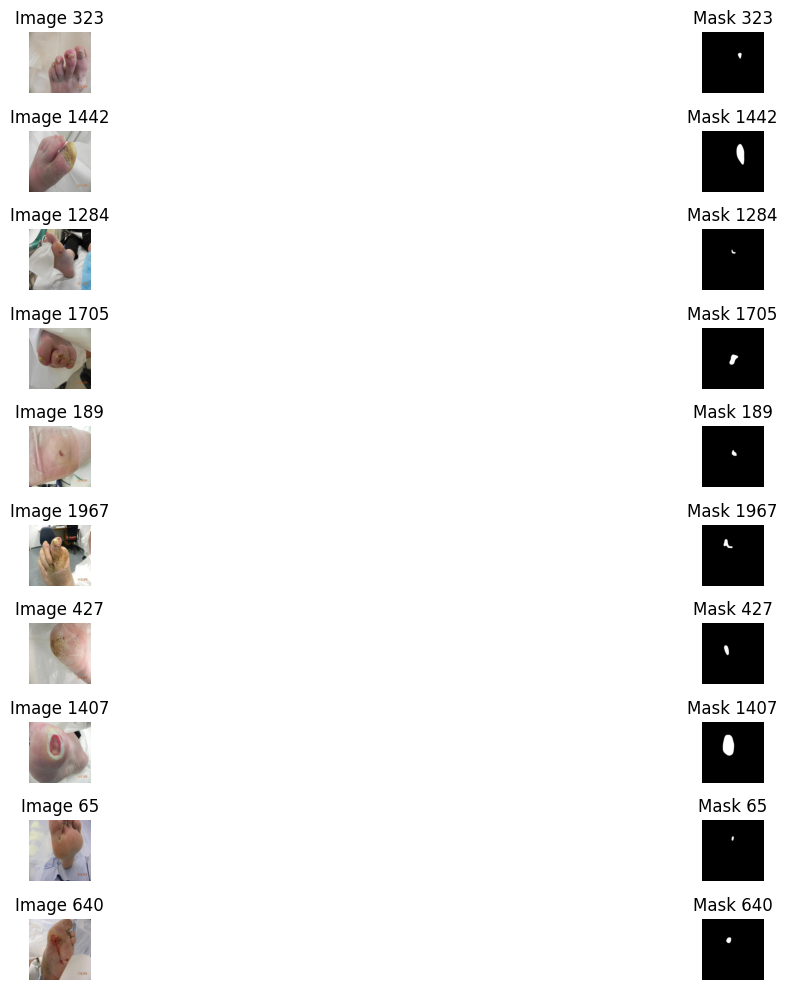

In [ ]:
def display_images_and_masks(image_paths, mask_paths, num_images=10):
    random_indices = random.sample(range(len(image_paths)), num_images)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(random_indices):
        # Load and transform the image
        image = Image.open(image_paths[idx]).convert("RGB")
        mask = Image.open(mask_paths[idx]).convert("L")  # Assuming masks are single-channel

        # Apply transformations
        image = transform(image)
        mask = transform(mask)

        # Plotting
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert to HWC for plotting
        plt.title(f'Image {idx}')
        plt.axis('off')

        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')  # Assuming mask is grayscale
        plt.title(f'Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display images and masks
display_images_and_masks(image_paths, mask_paths, num_images=10)

# SEGMENTATION MODEL

In [ ]:
import torch.nn as nn
from torchvision import models

class FCN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FCN, self).__init__()

        # Load the FCN model with a ResNet backbone
        self.fcn = models.segmentation.fcn_resnet50(pretrained=True)

        # Adjust the first convolutional layer to accept the desired input channels
        self.fcn.backbone.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )

        # Replace the classifier to have the required output channels
        self.fcn.classifier = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, out_channels, kernel_size=1)
        )

    def forward(self, x):
        # Forward pass through FCN
        x = self.fcn(x)
        return x['out']  # Return the output from the segmentation head

In [ ]:
model = models.segmentation.fcn_resnet50(pretrained=True)  # Load a pre-trained FCN
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1))  # Adjust output layer for binary segmentation
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:03<00:00, 44.0MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Dice Coefficient for evaluation
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = preds > 0.5  # Binarize predictions
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

#TRAINING AND VALIDATION

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/checkpoint_fcn_kfold.pth'
if os.path.exists(checkpoint_path):
    print("Loading weights from checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_dice_score = checkpoint.get('best_dice_score', None)
else:
    print("No checkpoint found, starting training from scratch.")
    best_dice_score = 0


No checkpoint found, starting training from scratch.


In [ ]:
from sklearn.model_selection import KFold

# Define the number of splits for k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
from tqdm import tqdm

# K-Fold Training Loop
for fold, (train_indices, val_indices) in enumerate(kf.split(image_paths)):
    print(f'Fold {fold + 1}/{k_folds}')

    train_images = [image_paths[i] for i in train_indices]
    train_masks = [mask_paths[i] for i in train_indices]
    val_images = [image_paths[i] for i in val_indices]
    val_masks = [mask_paths[i] for i in val_indices]

    train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
    val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Model Initialization
    model = models.segmentation.fcn_resnet50(pretrained=True)  # Load a pre-trained FCN
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1))  # Adjust output layer for binary segmentation
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_dice_score = 0
    num_epochs = 10

    for epoch in range(num_epochs):
        # TRAINING PHASE
        model.train()
        total_loss = 0
        total_dice = 0
        with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                optimizer.zero_grad()
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                preds = torch.sigmoid(outputs)
                dice = dice_coefficient(preds, masks)
                total_dice += dice.item()

                avg_loss = total_loss / (pbar.n + 1)
                avg_dice = total_dice / (pbar.n + 1)

                pbar.set_postfix({'loss': avg_loss, 'dice': avg_dice})
                pbar.update(1)

        avg_loss = total_loss / len(train_loader)
        avg_dice = total_dice / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Dice Coefficient: {avg_dice:.4f}')

        # VALIDATION PHASE
        model.eval()
        val_loss = 0
        val_dice = 0
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            with torch.no_grad():
                for val_images, val_masks in val_loader:
                    val_images = val_images.to(device)
                    val_masks = val_masks.to(device)
                    val_outputs = model(val_images)['out']
                    loss = criterion(val_outputs, val_masks)

                    val_loss += loss.item()
                    val_preds = torch.sigmoid(val_outputs)
                    val_dice += dice_coefficient(val_preds, val_masks).item()

                    pbar.set_postfix({'val_loss': val_loss / (pbar.n + 1), 'val_dice': val_dice / (pbar.n + 1)})
                    pbar.update(1)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Dice Coefficient: {avg_val_dice:.4f}')

        # Save the model checkpoint
        if avg_val_dice > best_dice_score:
            best_dice_score = avg_val_dice
            # Optionally save the model state if required

print("K-Fold Cross-Validation completed.")

Fold 1/5


Training Epoch 1/10:   2%|▏         | 3/200 [02:01<2:12:44, 40.43s/batch, loss=0.705, dice=0.0756]


KeyboardInterrupt: 

# TESTING